## Introduction

## Imports

In [49]:
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline
import random



#Increases the resolution of the graphs rendered below by changing image format into vector
%config InlineBackend.figure_formats = ['svg']

In [50]:
#Importing the dataset
dataPath = "raw_data"
df = pd.read_csv(dataPath + "/data_salaries.csv")
#Displaying the first 10 instances of the dataset
df[0:10]

work_year experience_level employment_type                 job_title  \
0       2023               SE              FT  Principal Data Scientist   
1       2023               MI              CT               ML Engineer   
2       2023               MI              CT               ML Engineer   
3       2023               SE              FT            Data Scientist   
4       2023               SE              FT            Data Scientist   
5       2023               SE              FT         Applied Scientist   
6       2023               SE              FT         Applied Scientist   
7       2023               SE              FT            Data Scientist   
8       2023               SE              FT            Data Scientist   
9       2023               SE              FT            Data Scientist   

   salary salary_currency  salary_in_usd employee_residence  remote_ratio  \
0   80000             EUR          85847                 ES           100   
1   30000             USD          30000                 US           100   
2   25500             USD          25500                 US           100   
3  175000             USD         175000                 CA           100   
4  120000             USD         120000                 CA           100   
5  222200             USD         222200                 US             0   
6  136000             USD         136000                 US             0   
7  219000             USD         219000                 CA             0   
8  141000             USD         141000                 CA             0   
9  147100             USD         147100                 US             0   

  company_location company_size  
0               ES            L  
1               US            S  
2               US            S  
3               CA            M  
4               CA            M  
5               US            L  
6               US            L  
7               CA            M  
8               CA            M  
9               US            M

In [51]:
#Find the number of rows and columns in the dataset
print(df.shape)
#Find the different data types in the dataset
df.dtypes

(3755, 11)


work_year              int64
experience_level      object
employment_type       object
job_title             object
salary                 int64
salary_currency       object
salary_in_usd          int64
employee_residence    object
remote_ratio           int64
company_location      object
company_size          object
dtype: object

We can see that the distribution of the type of variables in this dataset is roughly 50% categorical and 50% continous, this indicates that we will have to spend roughly equivalent amount of time to look at those variables.

In [52]:
# All ten rows of the dataset all display 2023 for work year
# I want to see if there are other unique entries in this column
df['work_year'].unique()

array([2023, 2022, 2020, 2021])

In [53]:
# Summary statistics of the data
# For things like outliers or any weird stuff
print("Summary Statistics of Numerical Variables\n", 
      df.select_dtypes(include = "number").describe(),
     "\n")

print("Summary Statistics of Categorical Variables\n",
      df.select_dtypes(include = "object").describe(),
     "\n")

Summary Statistics of Numerical Variables
        work_year       salary  salary_in_usd  remote_ratio
count   3755.000     3755.000       3755.000      3755.000
mean    2022.374   190695.572     137570.390        46.272
std        0.691   671676.501      63055.625        48.589
min     2020.000     6000.000       5132.000         0.000
25%     2022.000   100000.000      95000.000         0.000
50%     2022.000   138000.000     135000.000         0.000
75%     2023.000   180000.000     175000.000       100.000
max     2023.000 30400000.000     450000.000       100.000 

Summary Statistics of Categorical Variables
        experience_level employment_type      job_title salary_currency  \
count              3755            3755           3755            3755   
unique                4               4             93              20   
top                  SE              FT  Data Engineer             USD   
freq               2516            3718           1040            3224   

       e

Looking at the above summary statistics we can see that remote ratios may be right skewed as the mean and median do not much. Additionally, for the salary column outliers may be present as the max value for the salary column is two magnitudes higher than the other entries measured in the column. From the categorical variables we can see that there are a lot of unique entries for job title, employee residence, and company location; this suggests that we may have to categorise these variables into smaller categories or encode them for easier data processing.

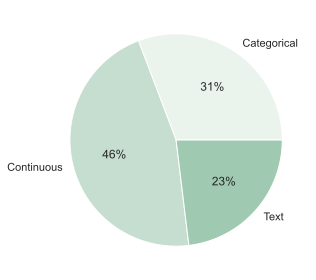

In [54]:
# Graph that illustrates the distribution of data types in this dataset
palette_color = sns.light_palette("seagreen")
FEATURES = [col for col in df.columns if col != 'work_year']
# Separate features into continuous and categorical features correctly
cont_features = [col for col in FEATURES if df[col].nunique() > 10]  # Adjust the threshold as needed
cat_features = [col for col in FEATURES if df[col].nunique() <= 10]  # Adjust the threshold as needed
text_features = ['job_title','company_location','employee_residence']

# Labels for plotting the pie chart
labels = ['Categorical', 'Continuous', 'Text']

# Finds the length of the each array and stores it into value
values= [len(cat_features), len(cont_features), len(text_features)]

# Plotting the pie chart
plt.pie(values, labels=labels, colors=palette_color, autopct='%.0f%%')
plt.show()

In [96]:
# Having a look at whether is there is any missing values for this dataset

print("Summary Statistics of Missing Values \n", 
      df.isnull().sum(axis=0),
     "\n")

Summary Statistics of Missing Values 
 work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
company_size_lab      0
dtype: int64 



No missing values for this dataset! This will make cleaning the data a lot easier.

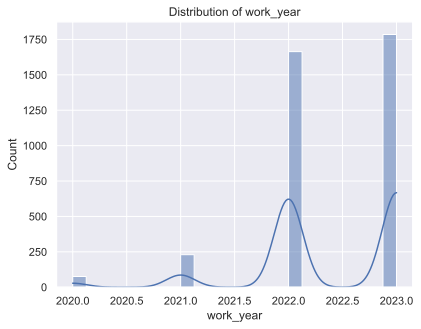

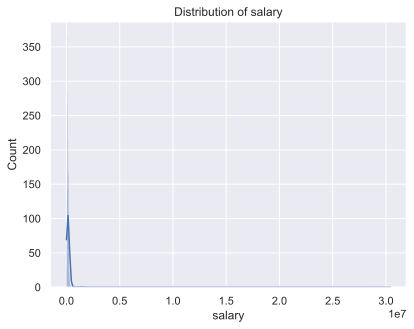

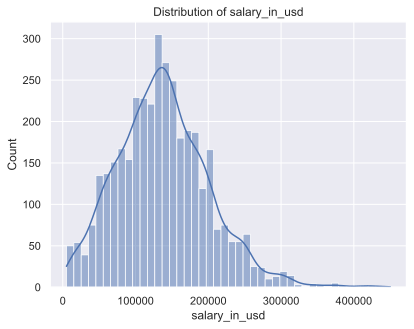

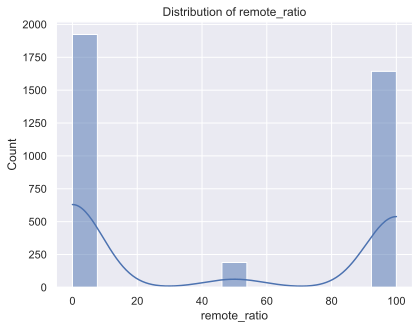

In [56]:
# This looks at the distribution of all numberical data 
for i, v in enumerate(df.select_dtypes(include = "number")):
    sns.histplot(df[v], kde = True)
    plt.title("Distribution of " + v)
    plt.show()

- Looking at work years it indicates to us that majority of the data in this dataset has been collected from 2022 and 2023 while there are some it does include some data from 2020 and 2021. 

- As for salary it seems like the graph looks odd due to the measurement, I will remove the convert it from scientific notation to normal numbers and have a look at the distribution again. 

- For salary in USD it appears like it is fairly normally distributed with a slight right skew - don't think we need to do anything here. 

- Remote ratio seems fairly interesting as it illustrates that most people are either work completely from the office or at home while a small minority is hybrid, I do think the data could be represented better via label encoding. 

0         80000
1         30000
2         25500
3        175000
4        120000
         ...   
3750     412000
3751     151000
3752     105000
3753     100000
3754    7000000
Name: salary, Length: 3755, dtype: int64


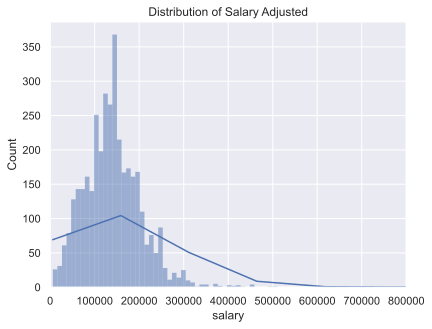

In [57]:
print(df['salary'])
pd.set_option('display.float_format', lambda x: f'{x:.3f}')
sns.histplot(df['salary'], kde = True)
plt.title("Distribution of Salary Adjusted")
plt.xlim(-0.02, 800000)
plt.show()

- After adjusting the X axis we can see that the data has a close to normal distribution and is a bit right skewed indicating the presence of outliers within the dataset. 

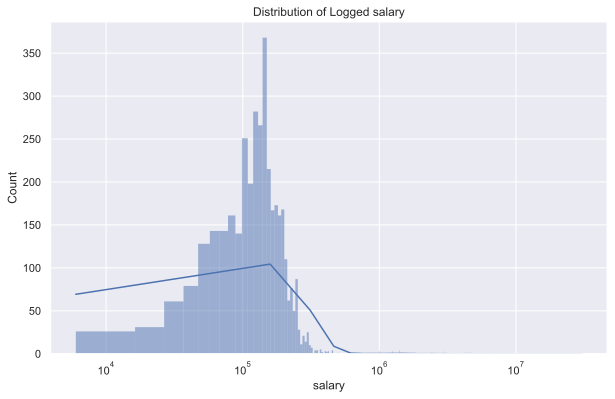

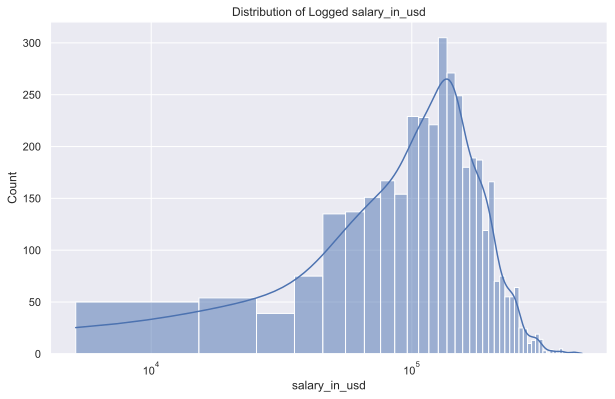

In [100]:
# Both salary in USD and salary are both right skewed 
# Lets try logging the data and see if it becomes more normally distrubted

for i, v in enumerate(["salary", "salary_in_usd",]):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[v], kde = True)
    plt.xscale("log")
    plt.title("Distribution of Logged " + v)
    plt.show()

- We can see that after logging the data the shape of the graph does not improve
- We should just stick to the original graph and instead clean the data later on in data cleaning

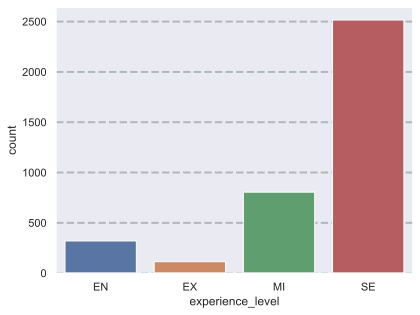

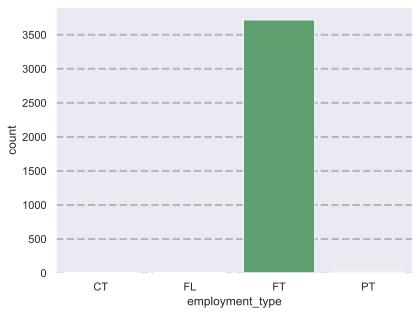

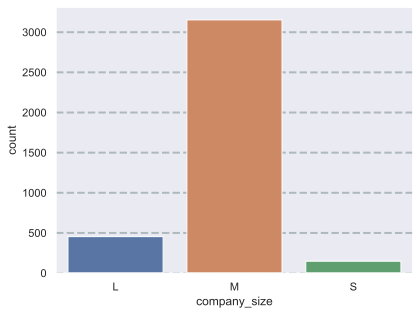

In [59]:
# Now lets proceed to look at the categorical variables


for i, v in enumerate(['experience_level','employment_type', 'company_size']):
    plt.figure(figsize=(10, 6))
    sns.countplot(x = df[v].astype('category'))
    plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
    plt.show()


There is a number of interesting things we can see from the categorical data above:
- Interestingly enough it seems like the most common experience level in this dataset is SE which typically corresponds to sensior or excutive level of experience.
- In terms of the employment type it appears like everyone falls under FT which typically corresponds to full time employment, will further verify there is no other unique entries.
- Medium sized company appears to be the most frequent

In [60]:
# Check the number of unique variables in the employment type column
print(df['employment_type'].unique())

# Checks the frequency of each variable in the column
df1 = df['employment_type'].value_counts()
print(df1)

['FT' 'CT' 'FL' 'PT']
FT    3718
PT      17
CT      10
FL      10
Name: employment_type, dtype: int64


From this we can see that the dataset doesn't only contain employees that are full there are other employment types as well with full time being the most common by a large margin. 

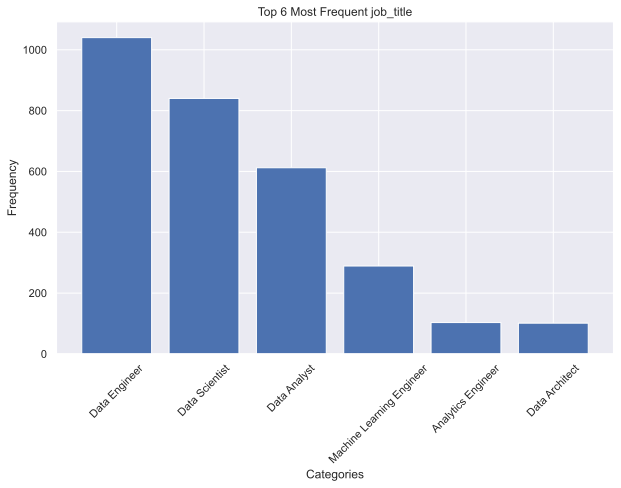

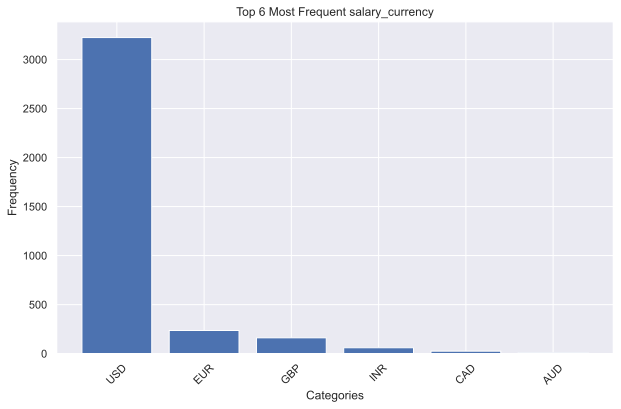

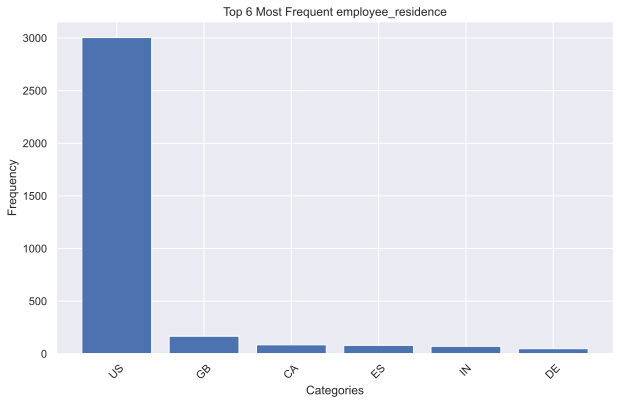

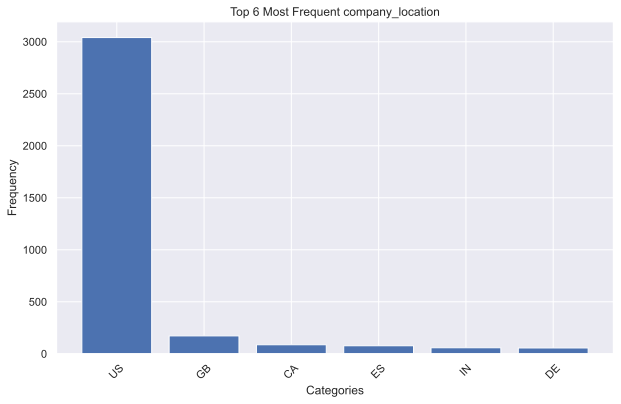

In [98]:

# Define number of top categories to display
top_n = 6

# Define list of columns to visualise
columns_to_visualise = ['job_title','salary_currency', 'employee_residence', 'company_location']

#Loop through each column
for col in columns_to_visualise:
    
    # Get the frequency counts of each category in the current column

    category_counts = df[col].value_counts()
    
    # Select the top N most frequent categories
    top_categories = category_counts.head(top_n)
    # Create a new figure for each column's visualization
    plt.figure(figsize=(10, 6))
    plt.bar(top_categories.index, top_categories.values)
    # Set labels and title for the plot

    plt.xlabel('Categories')
    plt.ylabel('Frequency')
    plt.title(f'Top {top_n} Most Frequent {col}')
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    # Display the plot
    plt.show()

From looking at the frequency graphs we can identify the following:
- The most common position in this dataset is data engineer
- For the categories with a lot of different variables such as company location and employee residence, although there is a large number of unique categories the most frequent is US by a large margin with only a small amount of individuals in other categories.
- Employee residence and company location may have a strong correlation which we can look at later

## Cateogrical Feature Conversion

In [88]:
# Encoding Spending_Score using label encoding
# Using label encoding as spending score is ordinal data

# Creating a instance of label encoder
le = LabelEncoder()
# Assigning numerical values and storing in another column

df['company_size_lab'] = le.fit_transform(df['company_size'])

/var/folders/k5/k1_9f5wd21sb8jb25qj3ldth0000gn/T/ipykernel_2523/3469211074.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(numeric_only=True), annot=True, mask=np.triu(df.corr()))


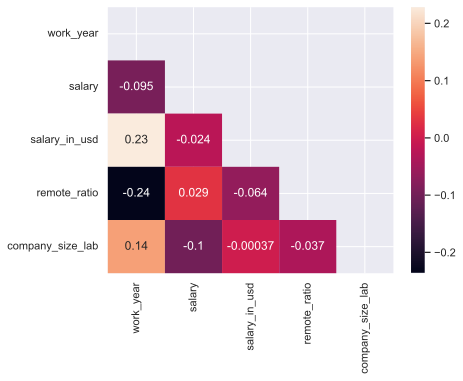

<Figure size 1000x600 with 0 Axes>

In [99]:
# Heatmap to visalise some correlation between variables 
sns.heatmap(df.corr(numeric_only=True), annot=True, mask=np.triu(df.corr()))
plt.show()

## Data Cleaning

In [89]:
df.head()

work_year experience_level employment_type                 job_title  \
0       2023               SE              FT  Principal Data Scientist   
1       2023               MI              CT               ML Engineer   
2       2023               MI              CT               ML Engineer   
3       2023               SE              FT            Data Scientist   
4       2023               SE              FT            Data Scientist   

   salary salary_currency  salary_in_usd employee_residence  remote_ratio  \
0   80000             EUR          85847                 ES           100   
1   30000             USD          30000                 US           100   
2   25500             USD          25500                 US           100   
3  175000             USD         175000                 CA           100   
4  120000             USD         120000                 CA           100   

  company_location company_size  company_size_lab  
0               ES            L                 0  
1               US            S                 2  
2               US            S                 2  
3               CA            M                 1  
4               CA            M                 1

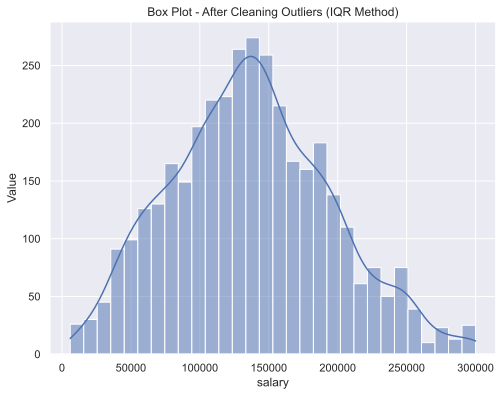

In [93]:
def clean_outliers_iqr(data, factor=1.5):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    return data[(data >= lower_bound) & (data <= upper_bound)]

cleaned_data = clean_outliers_iqr(df['salary'])


plt.figure(figsize=(8, 6))
sns.histplot(cleaned_data, kde = True)
plt.title("Box Plot - After Cleaning Outliers (IQR Method)")
plt.ylabel("Value")
plt.show()

In [94]:
df.isnull().values.any()

False